# Exoplanet cleaning and classification

Data described and downloaded from https://www.kaggle.com/keplersmachines/kepler-labelled-time-series-data/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
print(f'Tensorflow version: {tf.__version__}\nPandas version {pd.__version__}')

Tensorflow version: 2.0.0-beta1
Pandas version 1.0.0


In [3]:
train_data = pd.read_csv('./data/exoTrain.csv')

LABEL -> 2 is an exoplanet star and 1 is a non-exoplanet-star.

FLUX1-FLUX3197 -> the light intensity recorded for each star, at a different point in time.

In [4]:
train_data.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


## Data set bias
How many exoplanet vs non-exoplanet labels are there?

In [20]:
print(f'Number of exoplanet labels {sum(train_data.LABEL == 2)}')
print(f'Number of non-exoplanet labels {sum(train_data.LABEL == 1)}')

Number of exoplanet labels 37
Number of non-exoplanet labels 5050


So this is a very biased data set. Perhaps the 37 exoplanets are very large (similar size to Jupiter), but those planets are not as common as smaller planets.

Star 5017 is very interesting. Its a periodic signal but not contain a planet.

## Visualize exoplanet and non-exoplanet light curves.

In [22]:
n_plots = 5
n_smooth = 100

exo_df = train_data[train_data.LABEL == 2].sample(n=n_plots, random_state=123)
nonexo_df = train_data[train_data.LABEL == 1].sample(n=n_plots, random_state=123)

exo_df_rolling = exo_df.rolling(n_smooth, axis=1, center=True).mean()
nonexo_df_rolling = nonexo_df.rolling(n_smooth, axis=1, center=True).mean()

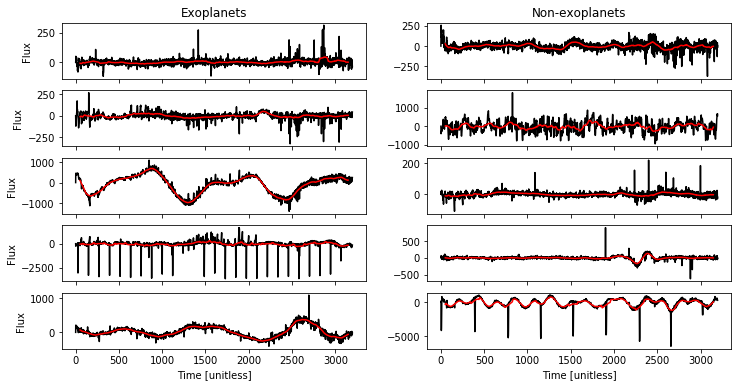

In [23]:
_, ax = plt.subplots(n_plots, 2, figsize=(12, 6), sharex=True)

for i, a in enumerate(ax[:, 0]): 
    a.plot(exo_df.iloc[i, :].values, 'k')
    a.plot(exo_df_rolling.values[i, :], 'r')
    a.set_ylabel('Flux')
for i, a in enumerate(ax[:, 1]): 
    a.plot(nonexo_df.iloc[i, :].values, 'k')
    a.plot(nonexo_df_rolling.values[i, :], 'r')
ax[0,0].set(title='Exoplanets')
ax[0,1].set(title='Non-exoplanets')
ax[-1,0].set_xlabel('Time [unitless]')
ax[-1,1].set_xlabel('Time [unitless]');

## Power spectrum
By visual inspection it is hard to tell the difference. What about the power spectrum?

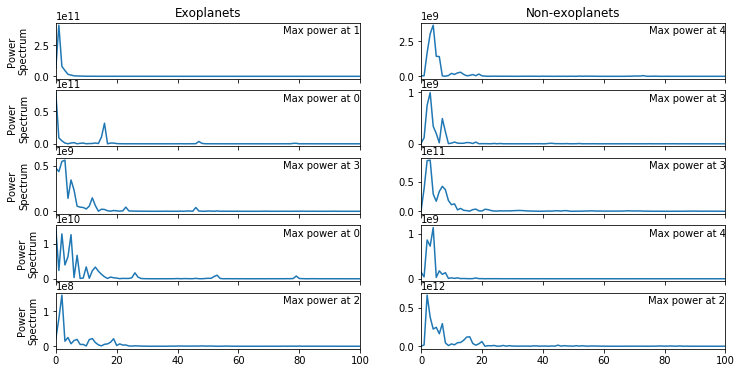

In [8]:
# Fill NaNs with 0s so numpy fft can handle the data correctly.
exo_df_rolling = exo_df_rolling.fillna(value=0)
nonexo_df_rolling = nonexo_df_rolling.fillna(value=0)

def calc_fourier_power(df):
    """
    Calculates the Fourier power spectrum and returns
    the frequency with the highest power.
    """
    ps = np.abs(np.fft.fft(df.values))**2
    max_power_f = np.argmax(ps[:len(ps)//2])
    return ps, max_power_f

### Plot the power spectra ###
_, ax = plt.subplots(n_plots, 2, figsize=(12, 6), sharex=True)

for i, a in enumerate(ax[:, 0]): 
    ps, max_power_f = calc_fourier_power(exo_df_rolling.iloc[i, :])
    a.plot(ps)
    a.text(1, 0.8, f'Max power at {max_power_f}', 
            ha='right', transform=a.transAxes)
    a.set_ylabel('Power\nSpectrum')

for i, a in enumerate(ax[:, 1]): 
    ps, max_power_f = calc_fourier_power(nonexo_df_rolling.iloc[i, :])
    a.text(1, 0.8, f'Max power at {max_power_f}', 
            ha='right', transform=a.transAxes)
    a.plot(ps)

ax[0,0].set(title='Exoplanets', xlim=(0, 100))
ax[0,1].set(title='Non-exoplanets');

There does not seem to be a pattern in this data so lets throw the biggest hammer we have.

# Train a Convolutional Neural Network clarrifier

In [18]:
def batch_generator(x_train, y_train, batch_size=32):
    """
    Gives equal number of positive and negative samples, and rotates them randomly in time
    """
    half_batch = batch_size // 2
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')
    
    yes_idx = np.where(y_train[:,0] == 1.)[0]
    non_idx = np.where(y_train[:,0] == 0.)[0]
    
    while True:
        np.random.shuffle(yes_idx)
        np.random.shuffle(non_idx)
    
        x_batch[:half_batch] = x_train[yes_idx[:half_batch]]
        x_batch[half_batch:] = x_train[non_idx[half_batch:batch_size]]
        y_batch[:half_batch] = y_train[yes_idx[:half_batch]]
        y_batch[half_batch:] = y_train[non_idx[half_batch:batch_size]]
    
        for i in range(batch_size):
            sz = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], sz, axis = 0)
     
        yield x_batch, y_batch

In [15]:
import tensorflow.keras.models
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
# from keras.models import Sequential
# from keras.layers import Dense, Dropout
# from keras.layers import Embedding
# from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

In [13]:
model = tensorflow.keras.models.Sequential()
model.add(Conv1D(filters=8, kernel_size=11, activation='relu', input_shape=[train_data.shape[1], 1]))
model.add(MaxPooling1D(strides=4))
# model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=11, activation='relu'))
model.add(MaxPooling1D(strides=4))
# model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=11, activation='relu'))
model.add(MaxPooling1D(strides=4))
# model.add(BatchNormalization())
model.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model.add(MaxPooling1D(strides=4))
model.add(Flatten())
# model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [16]:
model.compile(optimizer=Adam(1e-5), loss = 'binary_crossentropy', metrics=['accuracy'])

In [19]:
hist = model.fit_generator(batch_generator(x_train, y_train, 32), 
                           validation_data=(x_test, y_test), 
                           verbose=0, epochs=5,
                           steps_per_epoch=x_train.shape[1]//32)

NameError: name 'x_train' is not defined